## Diagnose K01 

w.r.t SAR wind speed amplitudes and asymmetries.

<u>NB</u>: The models are diagnosed for K = 50.

TODO: Also diagnose w.r.t the Ku-band scatterometer two-dimensional and average inflow angle (and perhaps its asymmetry?).

TODO: Change the filters to include only the cases that were considered valid in the other notebooks? In particular remove the non-C1 cases? If I don't want to re-compute the flags, just use .merge(join='inner');

MAYBE: Maybe compute the asymmetries in an other notebook? It takes a lot of time (the for loop goes from 1 min to 40 min to run). 

TODO: Diagnose K25 (maybe in another notebook? this would allow to gain some time [parallelizing] if I compute the asymetries here). 

<u>Conclusions</u>:

- K01_FIT is better than K01_PRM for all wind speed diagnostics, except for the amplitude of the asymmetry, that is better captured by K01_PRM in the near-core (1 < r* < 6), although better captured by K01_FIT in the outer-core (r* > 6).

In [1]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.interpolate import griddata
from scipy.optimize import minimize
from scipy.ndimage import gaussian_filter
from scipy.stats import gaussian_kde

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
# Paths & Params
PTHS = {
    'dsg_pth':     '/home/arthur/data/tropical_cyclones/SAR/parametric_dataset/dsg.nc',
    'sar_dir':     '/home/arthur/data/tropical_cyclones/SAR/S1_RS2_RCM/sar_files/',
    'K01_PRM_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_LP_KPP_K01/cases/',
    'K01_FIT_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01/cases/',
}

# Open data
dsg = xr.open_dataset(PTHS['dsg_pth'])

In [3]:
# FILTERS
cond = (
    (dsg.center_quality_flag < 2) & 
    (dsg.percent_outside < 50) & 
    (dsg.percent_rmx_inside == 1) &
    (abs(dsg.lat) < 30) & 
    (dsg.rmx < 100000) & 
    (dsg.vmx > 20) &

    (dsg.dist2coast  > dsg.r34)             & # Distance to coast
    (dsg.percent_outside < 10)                & # Sufficient SAR coverage
    # (dkg01.vmx > 20)                            & # Test
    # (dkg01.C_K01 != 0.0001)                     & # Reached the lower bound
    # (dkg01.C_K01 != 0.1)                        & # Reached the upper bound
    # (dkg01.asym_avg_err  <= 2.5)                & # Test
    # (dkg01.phase_avg_err <= 45)                 & # Test
    # (~xr.where(dkg01.non_C1 == 0, False, True)) & # Ensure that I > V/r
    ((dsg.storm_speed_ibt / dsg.vws_pmd) > 1) # Ratio storm_speed / wind_shead
)
dsg_filtered    = dsg.where(cond, drop=True)
print(len(dsg_filtered.time))

117


In [4]:
#########################
### General functions ###
#########################
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter assuming it's constant 
    return fcor

def holland_profile(r, lat, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor   = abs(coriolis(lat))
    rho    = 1.15
    r      = r.astype(float) + 0.001           # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt( ((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

#########################
###   MODEL FITTING   ###
#########################
def wind_reduction_factor(Rs, Vs, K, C, fcor):
    '''wrf = surface azim. wind / gradient azim. wind'''
    ki_cst  = ki(Rs, Vs, K, C, fcor)
    num     = ki_cst ** 2 + 2 * ki_cst + 2
    den     = 2 * ki_cst ** 2 + 3 * ki_cst + 2
    return num / den

def wn1(thetas, a, phi, c):
    return a * np.cos(thetas + phi) + c

def get_wn1(thetas, wind_speed, initial_condition=15, upper_bound=80):
    '''
    initial_condition: initial conidition for the amplitude and the constant c (just put Vplus)
    upper_bound: upper bound for the the amplitude and the constant c (just put Vmax)
    '''
    # Fitting process
    popt, pcov = curve_fit(
        f=wn1,
        xdata=thetas,
        ydata=wind_speed,
        p0=[initial_condition, np.pi / 2, initial_condition],
        bounds=([1., -2 * np.pi, 0.1], [upper_bound, 2 * np.pi, upper_bound]) # ([lower bounds], [upper bounds])
    )
    a, phi, c = popt[0], popt[1], popt[2]
    return a, phi, c

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

#########################
###       PLOT        ###
#########################
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def getColorMap(rgbFile="medspiration.rgb"):
    '''
    Load a RGB palette provided in ascii file
    '''
    colors = []
    nbCol  =0
    for line in open( rgbFile ):
        r,g,b = [int(c) for c in line.split()]
        colors.append( [r/255.,g/255.,b/255.] )
        nbCol += 1
    return(mpl.colors.ListedColormap(colors, name="custom", N=nbCol))

palette      = '/home/arthur/scripts/tools/high_wind_speed.pal'
cwnd         = getColorMap(rgbFile=palette)
normalizer   = Normalize(0, 80)

In [5]:
### FUNCTIONS TO COMPUTE ASYMMETRY AMPLITUDE
### FITS HOLLAND AT EACH RADIUS

def initialize_radius(spdm):
    '''Given the spdm, returns the largest radius (and asociated spdm) on which the profile can be fitted. 
    Indeed, sometimes the spdm isn't defined from r = 0 to r = 500, in this case the largest domain is taken instead.'''
    # Initialize first and last indexes
    first_valid_index = 0
    last_valid_index  = len(spdm)
    r                 = np.arange(last_valid_index) # to avoid having both r = 0 and n < 0 during fitting process
    
    ### Lower bound
    # We change it if spdm[0] = nan
    if np.isnan(spdm[0]):
        first_valid_index = np.min(np.where(np.isfinite(spdm)))
        
    ### Upper bound
    # We change it if there is a nan somewhere
    if np.isnan(np.min(spdm[first_valid_index:])):
        last_valid_index  = np.min(np.where(np.isnan(spdm[first_valid_index:]))[0]) # returns the index of the last valid value before the first nan
        last_valid_index += first_valid_index - 1
        
    # Define r and spdm
    r    = r[first_valid_index:last_valid_index] * 1000
    spdm = spdm[first_valid_index:last_valid_index]
    
    return r, spdm

# Test - Compute asymmetry by computing an average Holland per theta slice to smooth all the noise
BDS_HOL = {
    'B':      [0.01, 3.],
    'Vmin':   [0, 50],
    'Rmax':   [5 * 1000, 500 * 1000],
    'Vmax':   [10, 100],   
}

# Define the steps
# TODO: I could refine how I choose these steps to make them more continuous
# th_steps = np.linspace(0, 340, 341)
th_steps = np.linspace(0, 360, 19)[:-1] # Slice of 20 degrees
th_delta = 20 # degrees

In [6]:
# Avant d'afficher les informations, nous devons les calculer à partir de vos données nettoyées (wspds_dsp_cleaned et wspds_dsk_prm_cleaned).
# Bias (Biais): C'est une mesure de l'erreur systématique. On peut le calculer comme la différence moyenne entre les deux séries de vitesses. Par exemple, mean(wspds_dsk_prm_cleaned - wspds_dsp_cleaned).
# Standard Deviation (Écart-type): L'écart-type de la différence entre les deux séries. C'est une mesure de la dispersion de cette différence. std(wspds_dsk_prm_cleaned - wspds_dsp_cleaned).
# Correlation (Corrélation): Le coefficient de corrélation de Pearson entre les deux séries de vitesses. Il indique la force et la direction de la relation linéaire. np.corrcoef(wspds_dsp_cleaned, wspds_dsk_prm_cleaned)[0, 1].
# Scatter Index (SI): Souvent utilisé pour évaluer la performance d'un modèle. Il est défini comme l'écart-type des différences divisé par la moyenne des observations (souvent la moyenne du premier dataset ou la moyenne globale). std(diff) / mean(wspds_dsp_cleaned).
# Number of Points (N): Le nombre de paires de points valides utilisées après le nettoyage. len(wspds_dsp_cleaned).

In [7]:
# r_star
r_star = np.linspace(0, 16, 16 * 8 + 1)

# Fit Holland
rs            = np.linspace(1000, 5e5, 500)

In [8]:
### Initialize
listOfWspds_dsp     = [] # SAR
# K01 param
listOfWspds_dsk_prm = [] # K01 param
wspd_diffs_k01p     = [] # Wind speed diffs,                       
wspd_res_k01p       = [] # Wind speed relative errors,             
aamp_diffs_k01p     = [] # Asymmetry amplitude diffs,              
aamp_res_k01p       = [] # Asymmetry amplitude relative errors,    
aphs_diffs_k01p     = [] # Asymmetry phase of max. diffs,          
# K01 fit
listOfWspds_dsk_fit = [] # K01 param
wspd_diffs_k01f     = [] # Wind speed diffs,                       
wspd_res_k01f       = [] # Wind speed relative errors,             
aamp_diffs_k01f     = [] # Asymmetry amplitude diffs,              
aamp_res_k01f       = [] # Asymmetry amplitude relative errors,    
aphs_diffs_k01f     = [] # Asymmetry phase of max. diffs,          

for t in tqdm(range(len(dsg_filtered.time))):
    # Open
    ds         = dsg_filtered.isel(time=t)
    dsp        = xr.open_dataset(PTHS['sar_dir'] + ds.file_tcva.item()).isel(time=0)
    dsk_prm    = xr.open_dataset(PTHS['K01_PRM_dir'] + ds.file_tcva.item()[:-17] + '.nc').sel(z=10, theta=slice(0, 359))
    dsk_fit    = xr.open_dataset(PTHS['K01_FIT_dir'] + ds.file_tcva.item()[:-17] + '.nc').sel(z=10).interp(theta=np.array(dsp.theta))

    # Interpolate on r_star
    dss, dkp, dkf  = dsp.copy(deep=True), dsk_prm.copy(deep=True), dsk_fit.copy(deep=True)
    dss['rad']     = dss['rad'] / float(ds.rmx)
    dkp['rad']     = dkp['rad'] / float(ds.rmx)
    dkf['rad']     = dkf['rad'] / float(ds.rmx)
    wspd_diff_k01p = np.subtract(np.array(dss.wind_speed.transpose().interp(rad=r_star)), np.array(dkp.wind_speed.interp(rad=r_star)))
    wspd_re_k01p   = np.divide(wspd_diff_k01p, np.array(dss.wind_speed.transpose().interp(rad=r_star)))
    wspd_diff_k01f = np.subtract(np.array(dss.wind_speed.transpose().interp(rad=r_star)), np.array(dkf.wind_speed.interp(rad=r_star)))
    wspd_re_k01f   = np.divide(wspd_diff_k01f, np.array(dss.wind_speed.transpose().interp(rad=r_star)))

    ### Asymmetries
    ## K01 param, r_star
    aks         = []
    pks         = []
    # Iterate over all radii
    for rad in r_star[1:]: # Iterate only in the valid range to optimize time
        try:
            ak, phi, _  = get_wn1(np.deg2rad(dkp.theta), dkp.wind_speed.sel(rad=rad, method='nearest'), float(ds.vmx) / 3, float(ds.vmx))
        except RuntimeError:
            ak = phi = np.nan
        aks.append(ak)
        pks.append(phi)
    ## K01 fit, r_star
    aks_k01f = []
    pks_k01f = []
    # Iterate over all radii
    for rad in r_star[1:]: # Iterate only in the valid range to optimize time
        try:
            ak, phi, _  = get_wn1(np.deg2rad(dkf.theta), dkf.wind_speed.sel(rad=rad, method='nearest'), float(ds.vmx) / 3, float(ds.vmx))
        except RuntimeError:
            ak = phi = np.nan
        aks_k01f.append(ak)
        pks_k01f.append(phi)
    ## SAR, r_star
    # Initialize
    LWS = [] # To save the Holland wind speeds
    # ERR = [] # To compute RMSE
    ACN = [] # Amplitude of cosine
    PHS = [] # Phase of cosine
    # VTS = [] # Nb of valid thetas
    
    # Fit Holland for each theta
    for th in th_steps:
        ds_slice          = dsp.sel(theta=slice(th, th + th_delta))
        wsm               = ds_slice.wind_speed.mean(dim='theta', skipna=True)
        r_crop, spdm_crop = initialize_radius(np.array(wsm))
    
        try:
            # Holland
            popt, pcov = curve_fit(
                lambda r, B, Vmin, Rmax, Vmax: holland_profile(r, abs(float(ds.lat)), B, Vmin, Rmax, Vmax), 
                np.array(r_crop), 
                np.array(spdm_crop), 
                p0=[1.8, 5, 20 * 1000, 40], 
                bounds=(
                    tuple([BDS_HOL[e][0] for e in BDS_HOL.keys()]), # NB: lat is fixed
                    tuple([BDS_HOL[e][1] for e in BDS_HOL.keys()])
                ) 
            ) 
            B_hol, vmn_hol, rmx_hol, vmx_hol = popt
            
        except RuntimeError:
            B_hol = vmn_hol = rmx_hol = vmx_hol = np.nan
        
        # Append
        LWS.append(holland_profile(rs, abs(float(ds.lat)), B_hol, vmn_hol, rmx_hol, vmx_hol))
    
    # Create dataset with Holland for each theta
    dsh = xr.Dataset(
        data_vars={
            'ws':        (('th', 'rad'), LWS),
        },
        coords={
            'th': th_steps,
            'rad': rs,
        }
    )
    
    # Interpolate on r*
    dsh['rad']     = dsh['rad'] / float(ds.rmx)
    dsh.interp(rad=r_star)
    
    # Compute asymmetries
    for rad in r_star[1:]:
        # Amplitude of cosine
        if np.count_nonzero(np.isnan(dsh.sel(rad=rad, method='nearest').ws)) == 0:
            acn, phi, c = get_wn1(np.deg2rad(dsh.sel(rad=rad, method='nearest').th), dsh.sel(rad=rad, method='nearest').ws, float(ds.vmx) / 3, float(ds.vmx))
        else:
            acn = phi = c = np.nan
        ACN.append(acn)
        PHS.append(phi)
        # # Error
        # error         = float(rmse(dsh.sel(rad=rad, method='nearest').ws, wn1(np.deg2rad(dsh.th), acn, phi, c))) 
        # ERR.append(error)
        # # Valid thetas
        # VTS.append(len(dsp.sel(rad=rad, method='nearest').dropna(subset=['wind_speed'], dim='theta').theta))

    ## Differences and relative errors
    # K01 param
    aamp_diff_k01p = np.subtract(np.array(ACN), np.array(aks))
    aamp_re_k01p   = np.divide(aamp_diff_k01p, np.array(ACN))
    aphs_diff_k01p = np.minimum(abs(np.subtract(np.array(PHS), np.array(pks))), 360 - abs(np.subtract(np.array(PHS), np.array(pks))))
    # aphs_diff_k01p = np.subtract(np.array(PHS), np.array(pks))
    # aphs_re_k01p   = np.divide(aamp_diff_k01p, np.array(PHS))
    # K01 fit
    aamp_diff_k01f = np.subtract(np.array(ACN), np.array(aks_k01f))
    aamp_re_k01f   = np.divide(aamp_diff_k01f, np.array(ACN))
    aphs_diff_k01f = np.minimum(abs(np.subtract(np.array(PHS), np.array(pks_k01f))), 360 - abs(np.subtract(np.array(PHS), np.array(pks_k01f))))
    # aphs_diff_k01f = np.subtract(np.array(PHS), np.array(pks_k01f))
    # aphs_re_k01f   = np.divide(aamp_diff_k01f, np.array(PHS))

    ### Append
    # SAR
    listOfWspds_dsp.append(np.array(dsp.wind_speed.transpose()).flatten())
    # K01 param
    listOfWspds_dsk_prm.append(np.array(dsk_prm.wind_speed).flatten())
    wspd_diffs_k01p.append(wspd_diff_k01p)
    wspd_res_k01p.append(wspd_re_k01p)
    aamp_diffs_k01p.append(aamp_diff_k01p)
    aamp_res_k01p.append(aamp_re_k01p)
    aphs_diffs_k01p.append(aphs_diff_k01p)
    # aphs_res_k01p.append(aphs_re_k01p)
    # K01 fit
    listOfWspds_dsk_fit.append(np.array(dsk_fit.wind_speed).flatten())
    wspd_diffs_k01f.append(wspd_diff_k01f)
    wspd_res_k01f.append(wspd_re_k01f)
    aamp_diffs_k01f.append(aamp_diff_k01f)
    aamp_res_k01f.append(aamp_re_k01f)
    aphs_diffs_k01f.append(aphs_diff_k01f)
    # aphs_res_k01f.append(aphs_re_k01f)

    # Close
    dsp.close()
    dsk_prm.close()
    dss.close()
    dkp.close()

  0%|          | 0/117 [00:00<?, ?it/s]

In [9]:
wspds_dsp     = np.concatenate(listOfWspds_dsp)
wspds_dsk_prm = np.concatenate(listOfWspds_dsk_prm)
wspds_dsk_fit = np.concatenate(listOfWspds_dsk_fit)

### K01 param

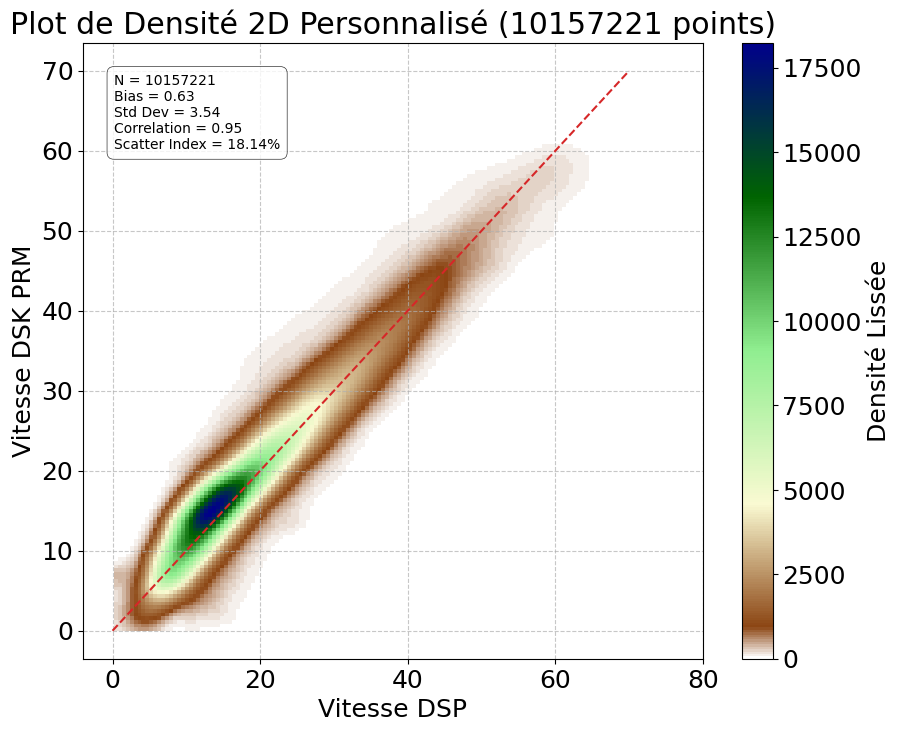

In [10]:
# --- Nettoyage des données ---
valid_mask = ~np.isnan(wspds_dsp) & ~np.isnan(wspds_dsk_prm)
wspds_dsp_cleaned = wspds_dsp[valid_mask]
wspds_dsk_prm_cleaned = wspds_dsk_prm[valid_mask]

if len(wspds_dsp_cleaned) == 0:
    print("Aucune donnée valide après le nettoyage des NaN.")
else:
    # --- Calcul de l'histogramme 2D (binning) ---
    num_bins = 150
    H, xedges, yedges = np.histogram2d(
        wspds_dsp_cleaned,
        wspds_dsk_prm_cleaned,
        bins=num_bins
    )

    sigma_smoothing = 2
    H_smoothed = gaussian_filter(H, sigma=sigma_smoothing)

    # --- Création de la colormap personnalisée ---
    colors = ["white",
              "saddlebrown",
              "lightgoldenrodyellow",
              "lightgreen",
              "darkgreen",
              "darkblue"]

    nodes = [0.0, 0.05, 0.25, 0.5, 0.75, 1.0]
    custom_cmap = LinearSegmentedColormap.from_list("my_custom_cmap", list(zip(nodes, colors)))

    # --- Tracé de la heatmap de densité lissée avec la nouvelle colormap ---
    plt.figure(figsize=(10, 8))

    plt.imshow(H_smoothed.T,
               origin='lower',
               extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
               cmap=custom_cmap,
               aspect='auto')
    plt.plot([0, 70], [0, 70], c='tab:red', linestyle='dashed')

    cbar = plt.colorbar()
    cbar.set_label('Densité Lissée')

    plt.title(f'Plot de Densité 2D Personnalisé ({len(wspds_dsp_cleaned)} points)')
    plt.xlabel('Vitesse DSP')
    plt.ylabel('Vitesse DSK PRM')
    plt.grid(True, linestyle='--', alpha=0.7)

    # --- Calcul des statistiques ---
    n_points = len(wspds_dsp_cleaned)
    if n_points > 1:
        differences = wspds_dsk_prm_cleaned - wspds_dsp_cleaned
        bias = np.mean(differences)
        std_dev = np.std(differences)
        correlation = np.corrcoef(wspds_dsp_cleaned, wspds_dsk_prm_cleaned)[0, 1]

        mean_dsp = np.mean(wspds_dsp_cleaned)
        if mean_dsp != 0:
            scatter_index = (std_dev / mean_dsp) * 100
        else:
            scatter_index = np.nan

        stats_text = (f"N = {n_points}\n"
                      f"Bias = {bias:.2f}\n"
                      f"Std Dev = {std_dev:.2f}\n"
                      f"Correlation = {correlation:.2f}\n"
                      f"Scatter Index = {scatter_index:.2f}%")

        # --- Modification pour placer l'encart en haut à gauche ---
        plt.text(0.05, 0.95, stats_text, # Changement des coordonnées x
                 transform=plt.gca().transAxes,
                 fontsize=10,
                 verticalalignment='top',
                 horizontalalignment='left', # Changement de l'alignement horizontal
                 bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8, ec='black', lw=0.5))
    else:
        print("Pas assez de points pour calculer les statistiques.")

    plt.show()

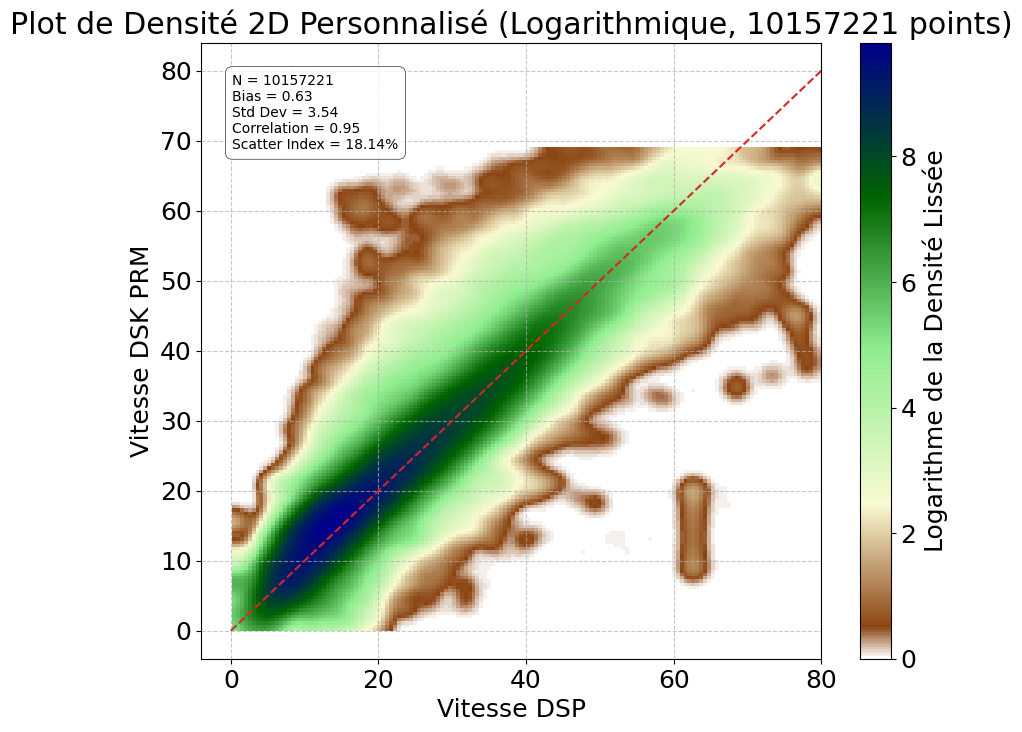

In [11]:
# --- Nettoyage des données ---
valid_mask = ~np.isnan(wspds_dsp) & ~np.isnan(wspds_dsk_prm)
wspds_dsp_cleaned = wspds_dsp[valid_mask]
wspds_dsk_prm_cleaned = wspds_dsk_prm[valid_mask]

if len(wspds_dsp_cleaned) == 0:
    print("Aucune donnée valide après le nettoyage des NaN.")
else:
    # --- Calcul de l'histogramme 2D (binning) ---
    num_bins = 150
    H, xedges, yedges = np.histogram2d(
        wspds_dsp_cleaned,
        wspds_dsk_prm_cleaned,
        bins=num_bins
    )

    sigma_smoothing = 2
    H_smoothed = gaussian_filter(H, sigma=sigma_smoothing)

    # --- Application du logarithme à la densité lissée ---
    # Nous utilisons np.log1p pour gérer les valeurs nulles de manière sûre
    H_smoothed_log = np.log1p(H_smoothed)

    # --- Création de la colormap personnalisée ---
    colors = ["white",
              "saddlebrown",
              "lightgoldenrodyellow",
              "lightgreen",
              "darkgreen",
              "darkblue"]

    nodes = [0.0, 0.05, 0.25, 0.5, 0.75, 1.0]
    custom_cmap = LinearSegmentedColormap.from_list("my_custom_cmap", list(zip(nodes, colors)))

    # --- Tracé de la heatmap de densité lissée avec la nouvelle colormap ---
    plt.figure(figsize=(10, 8))

    plt.imshow(H_smoothed_log.T, # Utilisation de la matrice logarithmique
               origin='lower',
               extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
               cmap=custom_cmap,
               aspect='auto')
    plt.plot([0, 80], [0, 80], c='tab:red', linestyle='dashed')

    cbar = plt.colorbar()
    cbar.set_label('Logarithme de la Densité Lissée') # Mise à jour de l'étiquette

    plt.title(f'Plot de Densité 2D Personnalisé (Logarithmique, {len(wspds_dsp_cleaned)} points)')
    plt.xlabel('Vitesse DSP')
    plt.ylabel('Vitesse DSK PRM')
    plt.grid(True, linestyle='--', alpha=0.7)

    # --- Calcul des statistiques ---
    n_points = len(wspds_dsp_cleaned)
    if n_points > 1:
        differences = wspds_dsk_prm_cleaned - wspds_dsp_cleaned
        bias = np.mean(differences)
        std_dev = np.std(differences)
        correlation = np.corrcoef(wspds_dsp_cleaned, wspds_dsk_prm_cleaned)[0, 1]

        mean_dsp = np.mean(wspds_dsp_cleaned)
        if mean_dsp != 0:
            scatter_index = (std_dev / mean_dsp) * 100
        else:
            scatter_index = np.nan

        stats_text = (f"N = {n_points}\n"
                      f"Bias = {bias:.2f}\n"
                      f"Std Dev = {std_dev:.2f}\n"
                      f"Correlation = {correlation:.2f}\n"
                      f"Scatter Index = {scatter_index:.2f}%")

        # --- Modification pour placer l'encart en haut à gauche ---
        plt.text(0.05, 0.95, stats_text,
                 transform=plt.gca().transAxes,
                 fontsize=10,
                 verticalalignment='top',
                 horizontalalignment='left',
                 bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8, ec='black', lw=0.5))
    else:
        print("Pas assez de points pour calculer les statistiques.")

    plt.show()

/tmp/ipykernel_76530/2883274196.py:3: RuntimeWarning: Mean of empty slice
  plt.pcolormesh(RSS, THS, np.nanmean(abs(np.stack(wspd_diffs_k01p)), axis=0), cmap=plt.get_cmap('Reds'), vmax=5)


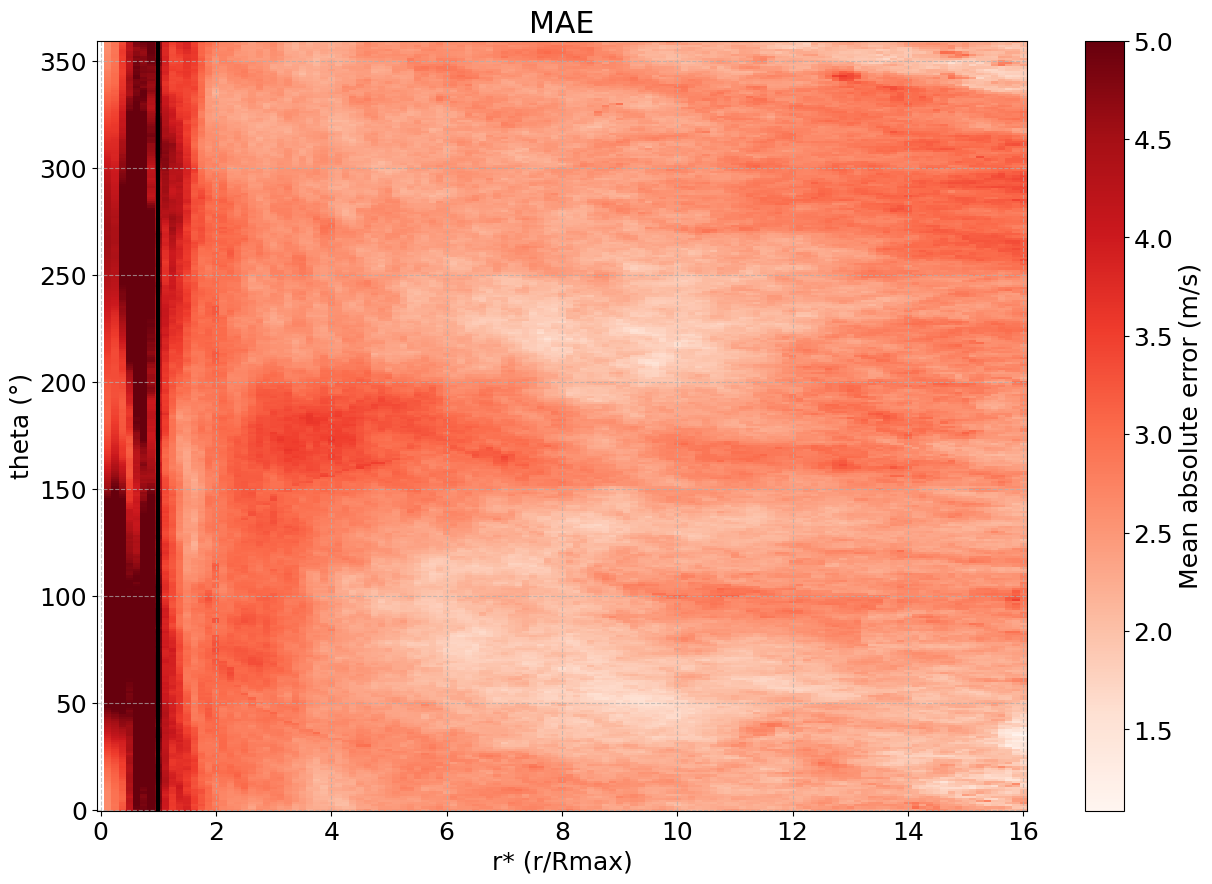

In [12]:
RSS, THS = np.meshgrid(r_star, np.array(dsp.theta))

plt.pcolormesh(RSS, THS, np.nanmean(abs(np.stack(wspd_diffs_k01p)), axis=0), cmap=plt.get_cmap('Reds'), vmax=5)

cbar = plt.colorbar()
cbar.set_label('Mean absolute error (m/s)') # Mise à jour de l'étiquette

plt.title(f'MAE')
plt.xlabel('r* (r/Rmax)')
plt.ylabel('theta (°)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.axvline(1, c='k', linewidth=3)

/tmp/ipykernel_76530/2515645310.py:3: RuntimeWarning: Mean of empty slice
  plt.pcolormesh(RSS, THS, 100 * np.nanmean(abs(np.stack(wspd_res_k01p)), axis=0), cmap=plt.get_cmap('Reds'), vmax=30)


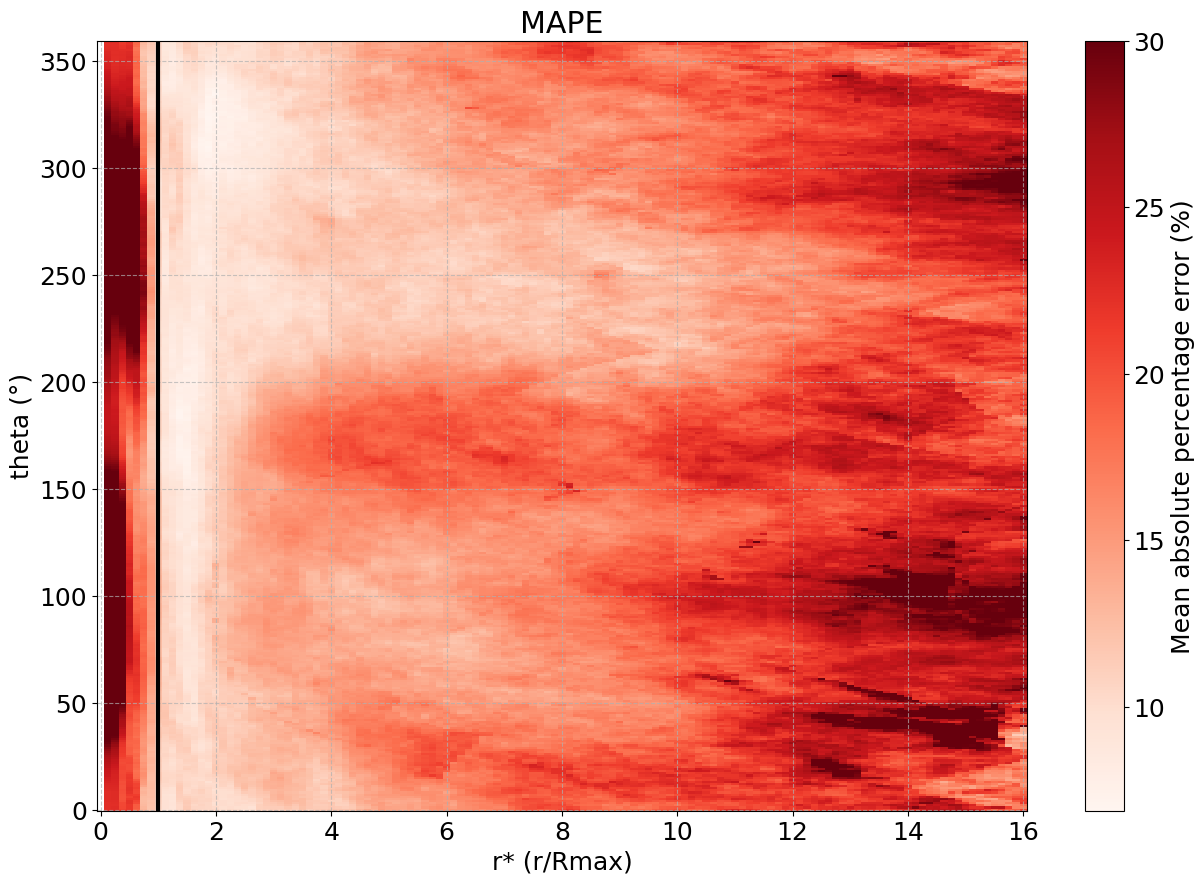

In [13]:
RSS, THS = np.meshgrid(r_star, np.array(dsp.theta))

plt.pcolormesh(RSS, THS, 100 * np.nanmean(abs(np.stack(wspd_res_k01p)), axis=0), cmap=plt.get_cmap('Reds'), vmax=30)

cbar = plt.colorbar()
cbar.set_label('Mean absolute percentage error (%)') # Mise à jour de l'étiquette

plt.title(f'MAPE')
plt.xlabel('r* (r/Rmax)')
plt.ylabel('theta (°)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.axvline(1, c='k', linewidth=3)

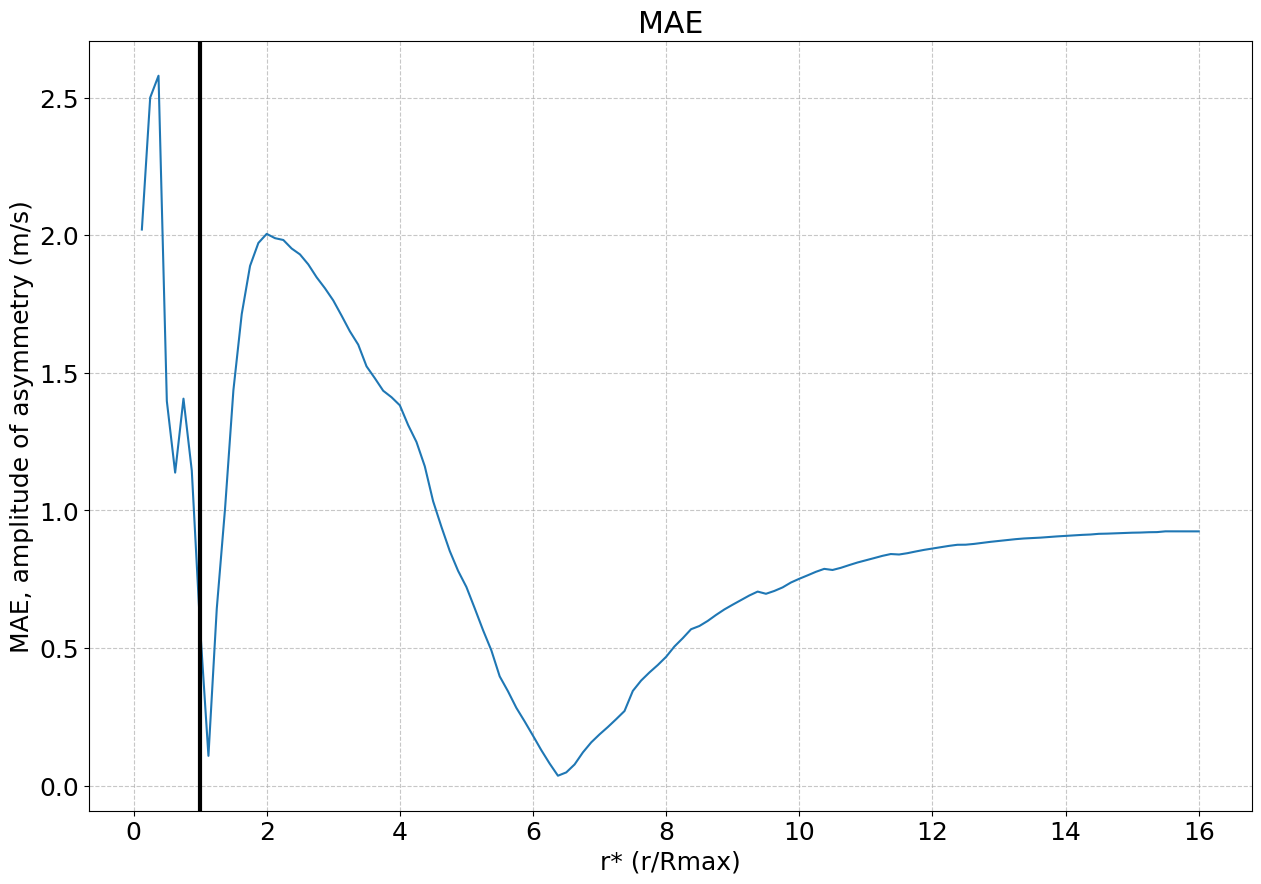

In [14]:
plt.plot(r_star[1:], abs(np.nanmean(aamp_diffs_k01p, axis=0)))

plt.title(f'MAE')
plt.xlabel('r* (r/Rmax)')
plt.ylabel('MAE, amplitude of asymmetry (m/s)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.axvline(1, c='k', linewidth=3)

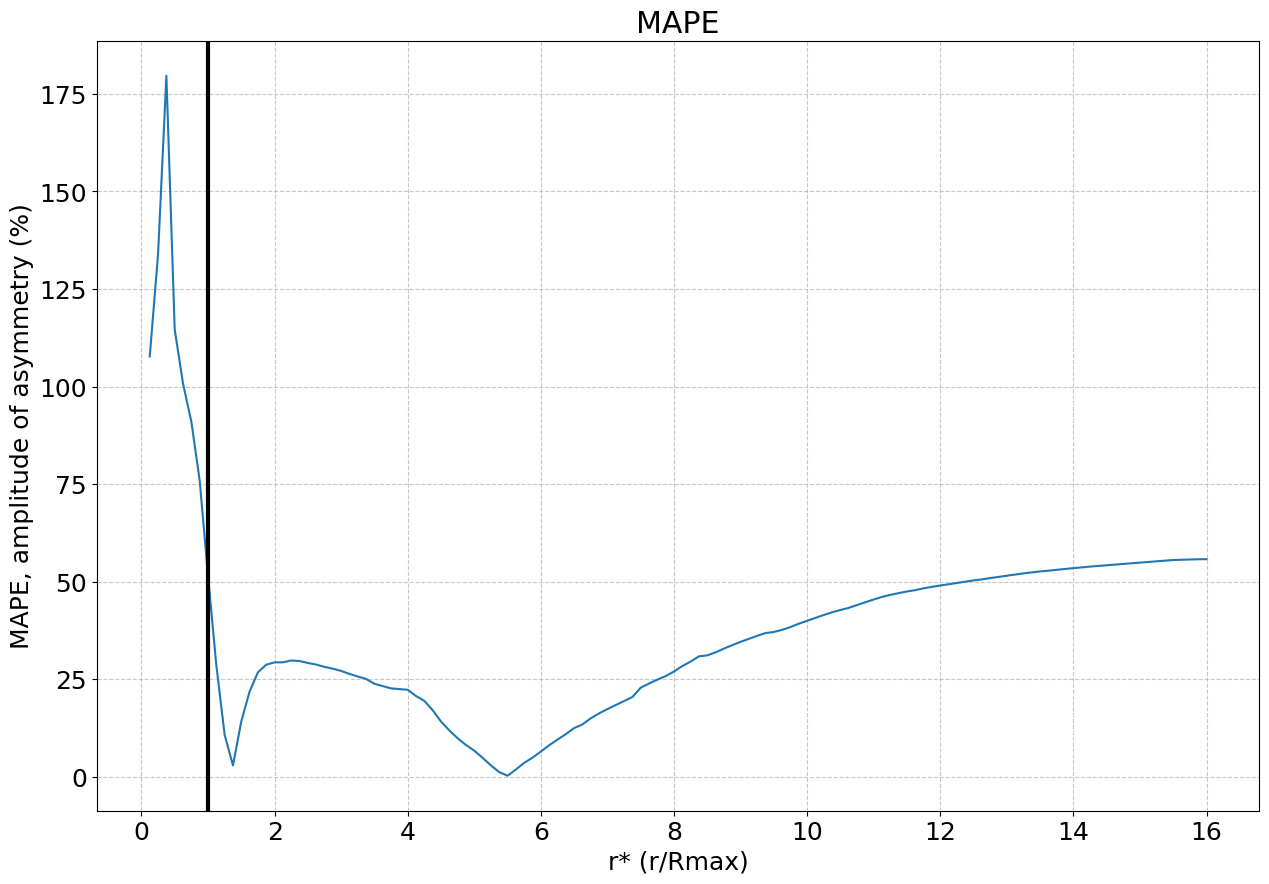

In [15]:
plt.plot(r_star[1:], 100 * abs(np.nanmean(aamp_res_k01p, axis=0)))

plt.title(f'MAPE')
plt.xlabel('r* (r/Rmax)')
plt.ylabel('MAPE, amplitude of asymmetry (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.axvline(1, c='k', linewidth=3)

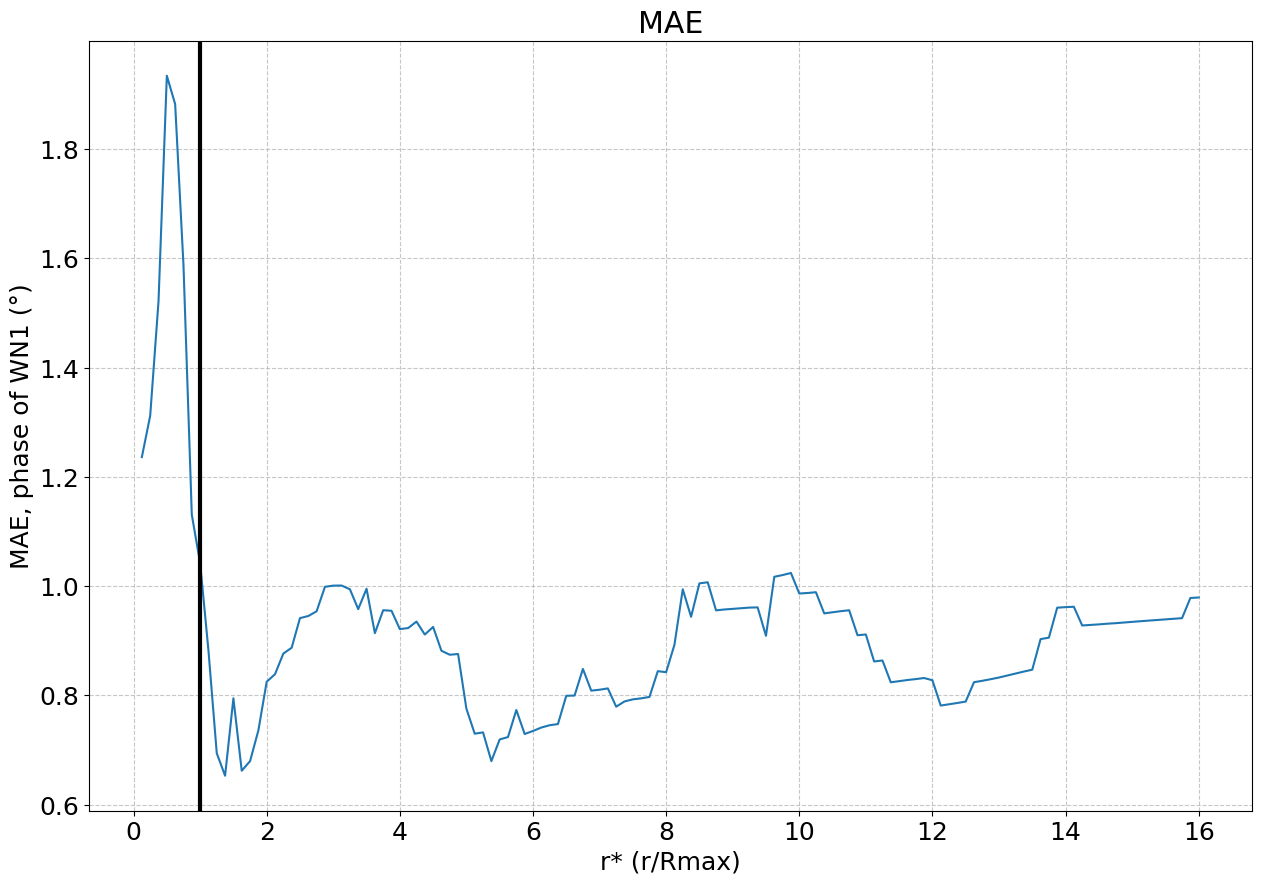

In [16]:
plt.plot(r_star[1:], abs(np.nanmean(aphs_diffs_k01p, axis=0)))

plt.title(f'MAE')
plt.xlabel('r* (r/Rmax)')
plt.ylabel('MAE, phase of WN1 (°)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.axvline(1, c='k', linewidth=3)

In [17]:
# plt.plot(r_star[1:], 100 * abs(np.nanmean(aphs_res_k01p, axis=0)))

# plt.title(f'MAPE')
# plt.xlabel('r* (r/Rmax)')
# plt.ylabel('MAPE, phase of WN1 (%)')
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.axvline(1, c='k', linewidth=3)
# plt.ylim(0, 100)

### K01 fit

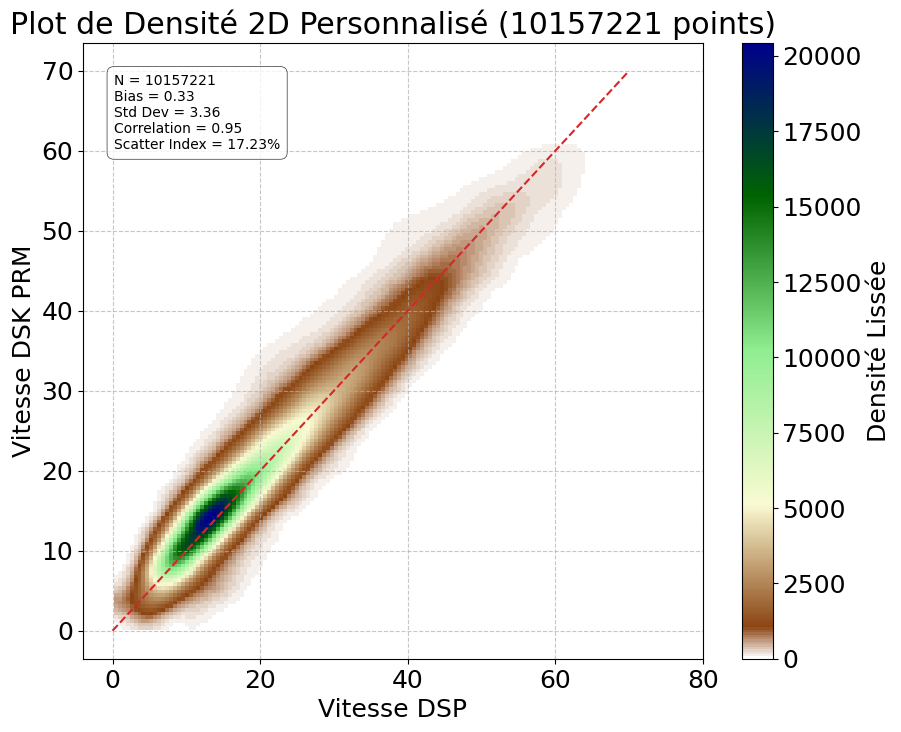

In [18]:
# --- Nettoyage des données ---
valid_mask = ~np.isnan(wspds_dsp) & ~np.isnan(wspds_dsk_fit)
wspds_dsp_cleaned = wspds_dsp[valid_mask]
wspds_dsk_fit_cleaned = wspds_dsk_fit[valid_mask]

if len(wspds_dsp_cleaned) == 0:
    print("Aucune donnée valide après le nettoyage des NaN.")
else:
    # --- Calcul de l'histogramme 2D (binning) ---
    num_bins = 150
    H, xedges, yedges = np.histogram2d(
        wspds_dsp_cleaned,
        wspds_dsk_fit_cleaned,
        bins=num_bins
    )

    sigma_smoothing = 2
    H_smoothed = gaussian_filter(H, sigma=sigma_smoothing)

    # --- Création de la colormap personnalisée ---
    colors = ["white",
              "saddlebrown",
              "lightgoldenrodyellow",
              "lightgreen",
              "darkgreen",
              "darkblue"]

    nodes = [0.0, 0.05, 0.25, 0.5, 0.75, 1.0]
    custom_cmap = LinearSegmentedColormap.from_list("my_custom_cmap", list(zip(nodes, colors)))

    # --- Tracé de la heatmap de densité lissée avec la nouvelle colormap ---
    plt.figure(figsize=(10, 8))

    plt.imshow(H_smoothed.T,
               origin='lower',
               extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
               cmap=custom_cmap,
               aspect='auto')
    plt.plot([0, 70], [0, 70], c='tab:red', linestyle='dashed')

    cbar = plt.colorbar()
    cbar.set_label('Densité Lissée')

    plt.title(f'Plot de Densité 2D Personnalisé ({len(wspds_dsp_cleaned)} points)')
    plt.xlabel('Vitesse DSP')
    plt.ylabel('Vitesse DSK PRM')
    plt.grid(True, linestyle='--', alpha=0.7)

    # --- Calcul des statistiques ---
    n_points = len(wspds_dsp_cleaned)
    if n_points > 1:
        differences = wspds_dsk_fit_cleaned - wspds_dsp_cleaned
        bias = np.mean(differences)
        std_dev = np.std(differences)
        correlation = np.corrcoef(wspds_dsp_cleaned, wspds_dsk_fit_cleaned)[0, 1]

        mean_dsp = np.mean(wspds_dsp_cleaned)
        if mean_dsp != 0:
            scatter_index = (std_dev / mean_dsp) * 100
        else:
            scatter_index = np.nan

        stats_text = (f"N = {n_points}\n"
                      f"Bias = {bias:.2f}\n"
                      f"Std Dev = {std_dev:.2f}\n"
                      f"Correlation = {correlation:.2f}\n"
                      f"Scatter Index = {scatter_index:.2f}%")

        # --- Modification pour placer l'encart en haut à gauche ---
        plt.text(0.05, 0.95, stats_text, # Changement des coordonnées x
                 transform=plt.gca().transAxes,
                 fontsize=10,
                 verticalalignment='top',
                 horizontalalignment='left', # Changement de l'alignement horizontal
                 bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8, ec='black', lw=0.5))
    else:
        print("Pas assez de points pour calculer les statistiques.")

    plt.show()

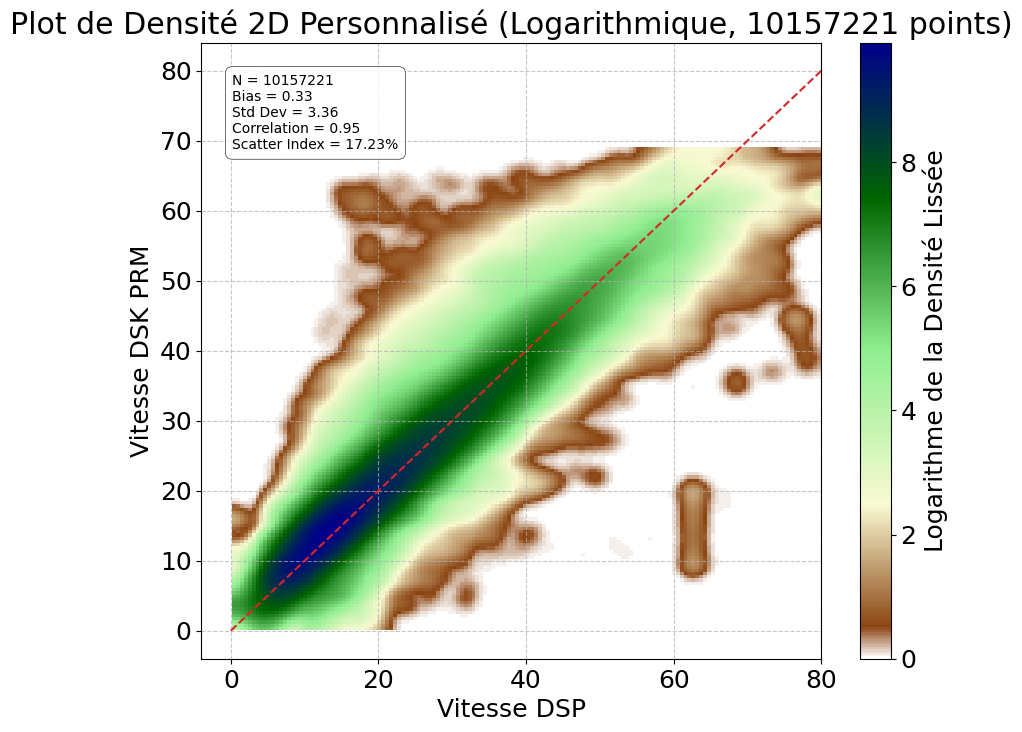

In [19]:
# --- Nettoyage des données ---
valid_mask = ~np.isnan(wspds_dsp) & ~np.isnan(wspds_dsk_fit)
wspds_dsp_cleaned = wspds_dsp[valid_mask]
wspds_dsk_fit_cleaned = wspds_dsk_fit[valid_mask]

if len(wspds_dsp_cleaned) == 0:
    print("Aucune donnée valide après le nettoyage des NaN.")
else:
    # --- Calcul de l'histogramme 2D (binning) ---
    num_bins = 150
    H, xedges, yedges = np.histogram2d(
        wspds_dsp_cleaned,
        wspds_dsk_fit_cleaned,
        bins=num_bins
    )

    sigma_smoothing = 2
    H_smoothed = gaussian_filter(H, sigma=sigma_smoothing)

    # --- Application du logarithme à la densité lissée ---
    # Nous utilisons np.log1p pour gérer les valeurs nulles de manière sûre
    H_smoothed_log = np.log1p(H_smoothed)

    # --- Création de la colormap personnalisée ---
    colors = ["white",
              "saddlebrown",
              "lightgoldenrodyellow",
              "lightgreen",
              "darkgreen",
              "darkblue"]

    nodes = [0.0, 0.05, 0.25, 0.5, 0.75, 1.0]
    custom_cmap = LinearSegmentedColormap.from_list("my_custom_cmap", list(zip(nodes, colors)))

    # --- Tracé de la heatmap de densité lissée avec la nouvelle colormap ---
    plt.figure(figsize=(10, 8))

    plt.imshow(H_smoothed_log.T, # Utilisation de la matrice logarithmique
               origin='lower',
               extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
               cmap=custom_cmap,
               aspect='auto')
    plt.plot([0, 80], [0, 80], c='tab:red', linestyle='dashed')

    cbar = plt.colorbar()
    cbar.set_label('Logarithme de la Densité Lissée') # Mise à jour de l'étiquette

    plt.title(f'Plot de Densité 2D Personnalisé (Logarithmique, {len(wspds_dsp_cleaned)} points)')
    plt.xlabel('Vitesse DSP')
    plt.ylabel('Vitesse DSK PRM')
    plt.grid(True, linestyle='--', alpha=0.7)

    # --- Calcul des statistiques ---
    n_points = len(wspds_dsp_cleaned)
    if n_points > 1:
        differences = wspds_dsk_fit_cleaned - wspds_dsp_cleaned
        bias = np.mean(differences)
        std_dev = np.std(differences)
        correlation = np.corrcoef(wspds_dsp_cleaned, wspds_dsk_fit_cleaned)[0, 1]

        mean_dsp = np.mean(wspds_dsp_cleaned)
        if mean_dsp != 0:
            scatter_index = (std_dev / mean_dsp) * 100
        else:
            scatter_index = np.nan

        stats_text = (f"N = {n_points}\n"
                      f"Bias = {bias:.2f}\n"
                      f"Std Dev = {std_dev:.2f}\n"
                      f"Correlation = {correlation:.2f}\n"
                      f"Scatter Index = {scatter_index:.2f}%")

        # --- Modification pour placer l'encart en haut à gauche ---
        plt.text(0.05, 0.95, stats_text,
                 transform=plt.gca().transAxes,
                 fontsize=10,
                 verticalalignment='top',
                 horizontalalignment='left',
                 bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8, ec='black', lw=0.5))
    else:
        print("Pas assez de points pour calculer les statistiques.")

    plt.show()

/tmp/ipykernel_76530/3603083770.py:3: RuntimeWarning: Mean of empty slice
  plt.pcolormesh(RSS, THS, np.nanmean(abs(np.stack(wspd_diffs_k01f)), axis=0), cmap=plt.get_cmap('Reds'), vmax=5)


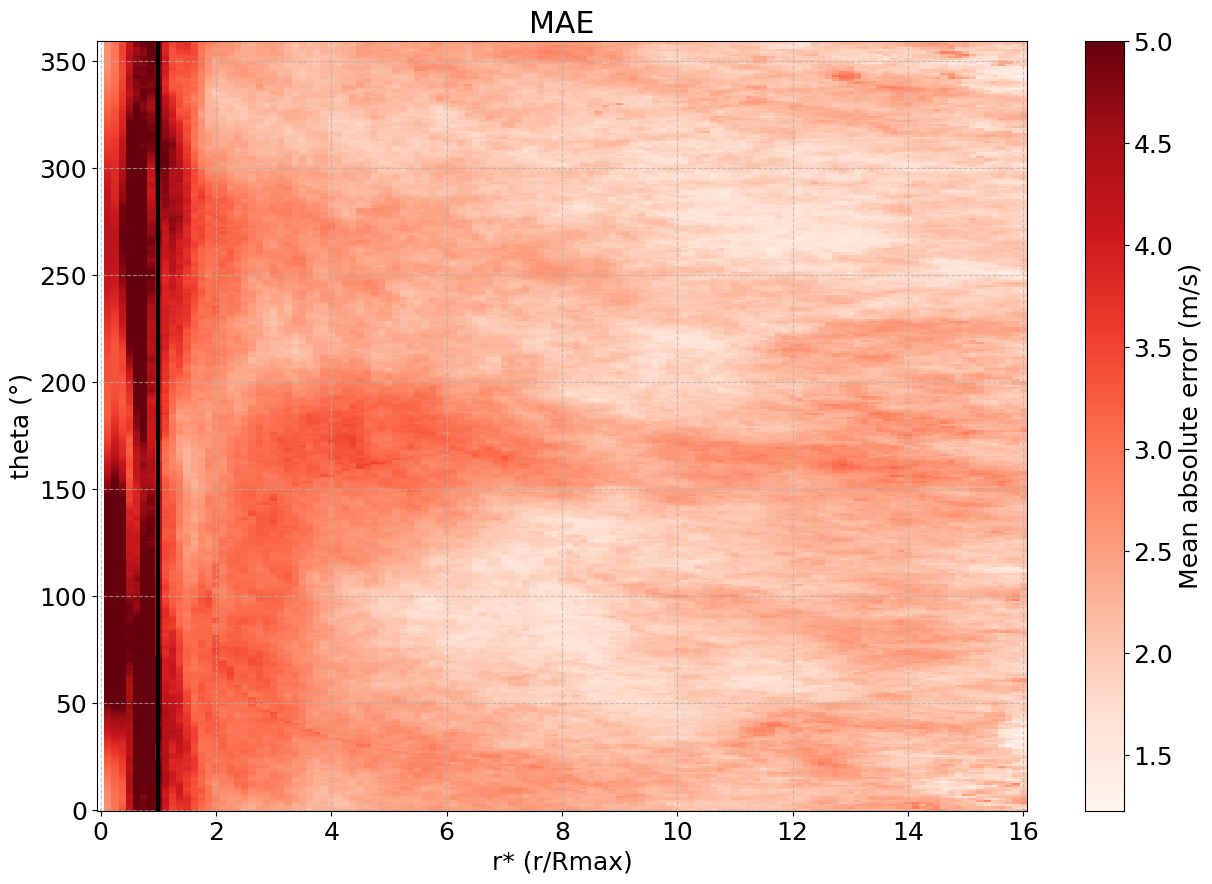

In [20]:
RSS, THS = np.meshgrid(r_star, np.array(dsp.theta))

plt.pcolormesh(RSS, THS, np.nanmean(abs(np.stack(wspd_diffs_k01f)), axis=0), cmap=plt.get_cmap('Reds'), vmax=5)

cbar = plt.colorbar()
cbar.set_label('Mean absolute error (m/s)') # Mise à jour de l'étiquette

plt.title(f'MAE')
plt.xlabel('r* (r/Rmax)')
plt.ylabel('theta (°)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.axvline(1, c='k', linewidth=3)

/tmp/ipykernel_76530/206378892.py:3: RuntimeWarning: Mean of empty slice
  plt.pcolormesh(RSS, THS, 100 * np.nanmean(abs(np.stack(wspd_res_k01f)), axis=0), cmap=plt.get_cmap('Reds'), vmax=30)


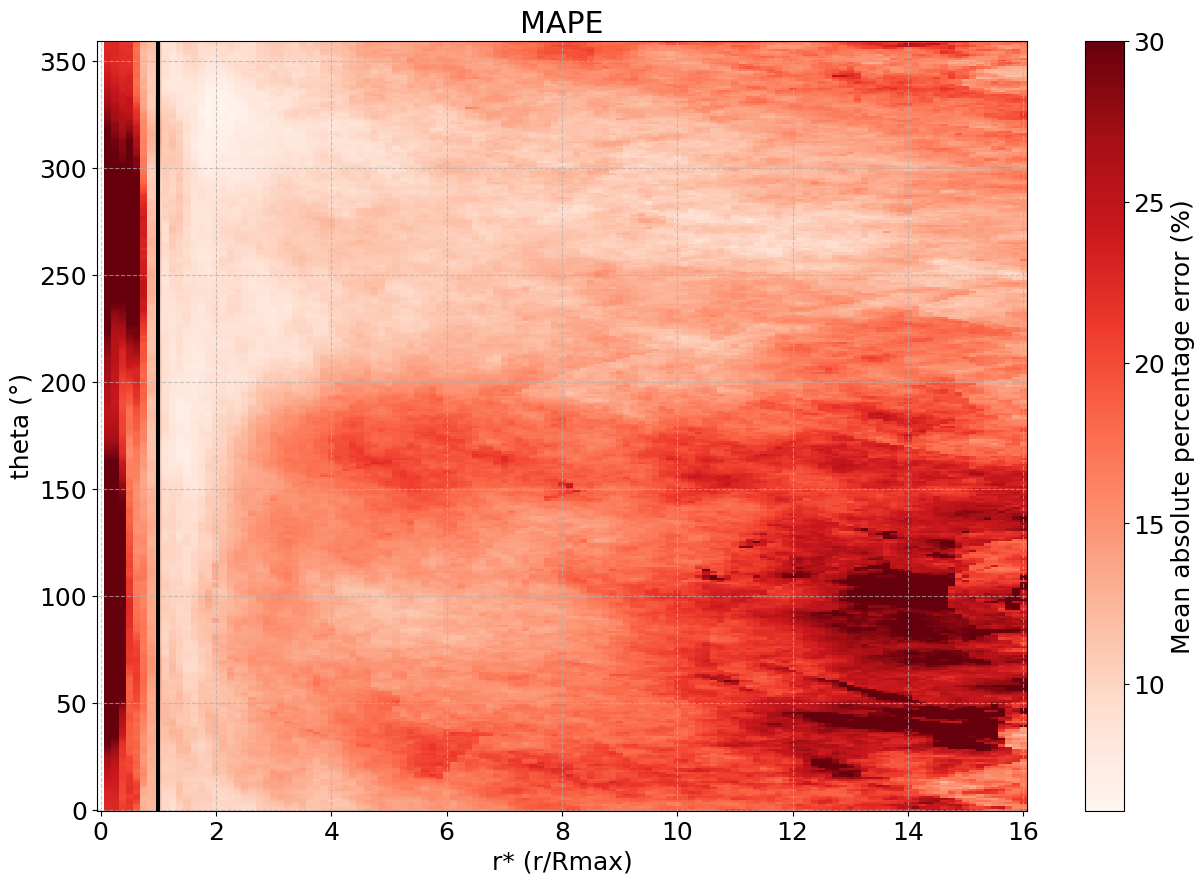

In [21]:
RSS, THS = np.meshgrid(r_star, np.array(dsp.theta))

plt.pcolormesh(RSS, THS, 100 * np.nanmean(abs(np.stack(wspd_res_k01f)), axis=0), cmap=plt.get_cmap('Reds'), vmax=30)

cbar = plt.colorbar()
cbar.set_label('Mean absolute percentage error (%)') # Mise à jour de l'étiquette

plt.title(f'MAPE')
plt.xlabel('r* (r/Rmax)')
plt.ylabel('theta (°)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.axvline(1, c='k', linewidth=3)

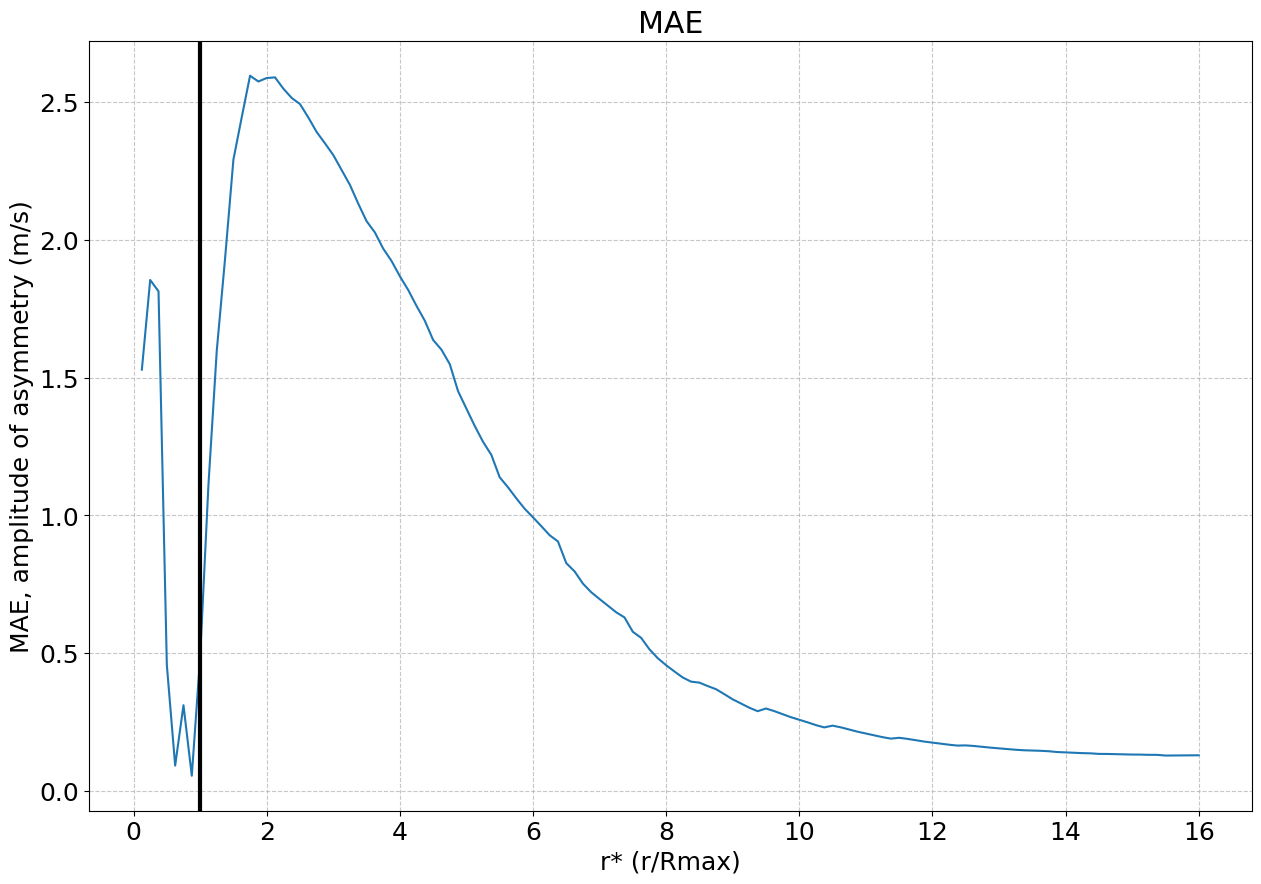

In [22]:
plt.plot(r_star[1:], abs(np.nanmean(aamp_diffs_k01f, axis=0)))

plt.title(f'MAE')
plt.xlabel('r* (r/Rmax)')
plt.ylabel('MAE, amplitude of asymmetry (m/s)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.axvline(1, c='k', linewidth=3)

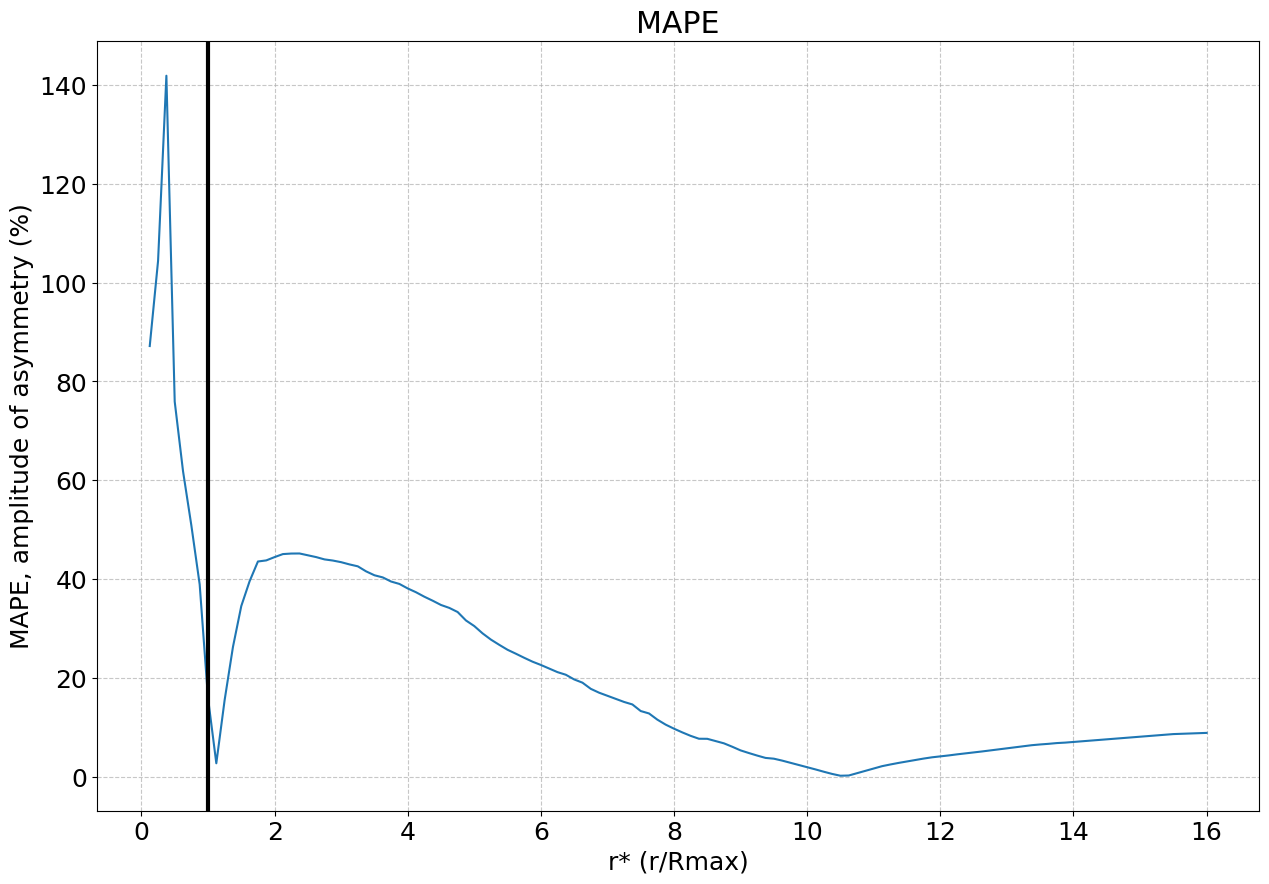

In [23]:
plt.plot(r_star[1:], 100 * abs(np.nanmean(aamp_res_k01f, axis=0)))

plt.title(f'MAPE')
plt.xlabel('r* (r/Rmax)')
plt.ylabel('MAPE, amplitude of asymmetry (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.axvline(1, c='k', linewidth=3)

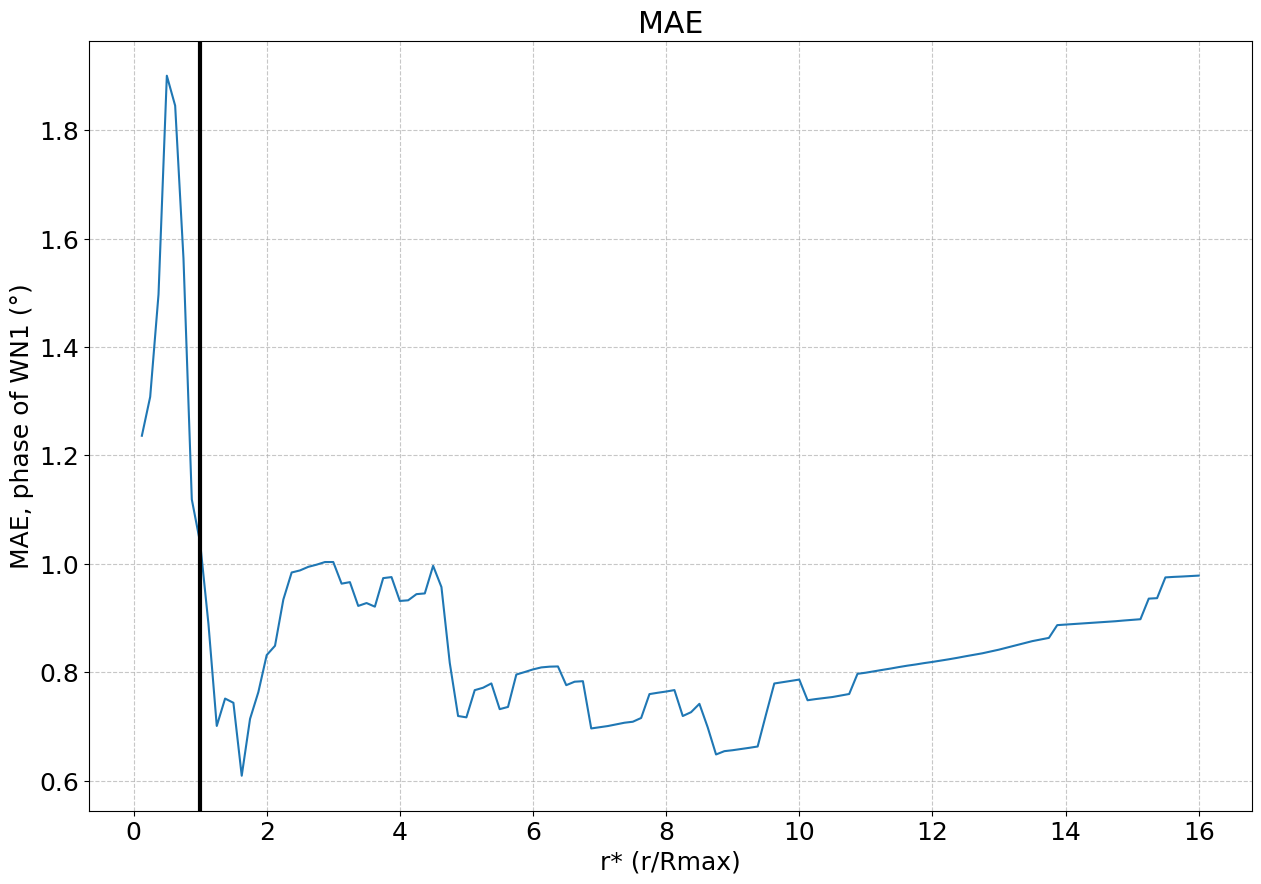

In [24]:
plt.plot(r_star[1:], abs(np.nanmean(aphs_diffs_k01f, axis=0)))

plt.title(f'MAE')
plt.xlabel('r* (r/Rmax)')
plt.ylabel('MAE, phase of WN1 (°)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.axvline(1, c='k', linewidth=3)

In [25]:
# plt.plot(r_star[1:], 100 * abs(np.nanmean(aphs_res_k01f, axis=0)))

# plt.title(f'MAPE')
# plt.xlabel('r* (r/Rmax)')
# plt.ylabel('MAPE, phase of WN1 (%)')
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.axvline(1, c='k', linewidth=3)
# plt.ylim(0, 100)